# Recurrent Neural Network trained on Aeneis

This project is based on Siraj Raval's ["Recurrent Neural Network - The Math of Intelligence (Week 5)"](https://www.youtube.com/watch?v=BwmddtPFWtA) Video. This is his [Jupyter Notebook](https://github.com/llSourcell/recurrent_neural_network/blob/master/RNN.ipynb) which is based on Andrej Karpathy's [Code](https://gist.github.com/karpathy/d4dee566867f8291f086)

## The code contains 4 parts
* Load the trainning data
  * encode char into vectors
* Define the Recurrent Network
* Define a loss function
  * Forward pass
  * Loss
  * Backward pass
* Define a function to visualize samples from the model
* Train the network
  * Feed the network
  * Calculate gradient and update the model parameters
  * Output a text to see the progress of the training
  
## Loading the data

In this case I am using Virgil's Aeneis as training data, which I got from [gutenberg.org](http://www.gutenberg.org/ebooks/227).

In [1]:
data = open('aeneis.txt').read()

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'Virgil\'s Aeneis is {data_size} characters long including {len(chars)} unique ones.')

Virgil's Aeneis is 484506 characters long including 82 unique ones.


### encoding/decoding

#### First let's create two dictionaries

In [2]:
char_to_ix = { ch:i for i,ch in enumerate(chars)}
ix_to_char = { i:ch for i, ch in enumerate(chars)}
print(char_to_ix)
print(ix_to_char)

{'j': 0, 'f': 1, 'Z': 2, ']': 3, '"': 4, 'N': 5, 'h': 6, '!': 7, '*': 8, '0': 9, '@': 10, '(': 11, 'R': 12, 'O': 13, '$': 14, 'd': 15, 'J': 16, 'U': 17, '?': 18, 'K': 19, 'k': 20, ',': 21, '5': 22, 'u': 23, 'n': 24, 'P': 25, '2': 26, '6': 27, '/': 28, '1': 29, 'M': 30, '\n': 31, '8': 32, ')': 33, '7': 34, 'm': 35, 'w': 36, '9': 37, 'z': 38, 'X': 39, 'o': 40, '-': 41, '[': 42, 'V': 43, 'F': 44, 'S': 45, '.': 46, 'c': 47, 'Q': 48, 'v': 49, 'r': 50, ' ': 51, 'A': 52, 'T': 53, 'G': 54, 'y': 55, "'": 56, 'C': 57, '%': 58, 't': 59, '3': 60, 'x': 61, 'L': 62, 'I': 63, 'E': 64, 'Y': 65, '4': 66, 'i': 67, 'e': 68, 'l': 69, 'H': 70, 'b': 71, ':': 72, 'p': 73, 'B': 74, 's': 75, ';': 76, 'D': 77, 'g': 78, 'a': 79, 'W': 80, 'q': 81}
{0: 'j', 1: 'f', 2: 'Z', 3: ']', 4: '"', 5: 'N', 6: 'h', 7: '!', 8: '*', 9: '0', 10: '@', 11: '(', 12: 'R', 13: 'O', 14: '$', 15: 'd', 16: 'J', 17: 'U', 18: '?', 19: 'K', 20: 'k', 21: ',', 22: '5', 23: 'u', 24: 'n', 25: 'P', 26: '2', 27: '6', 28: '/', 29: '1', 30: 'M', 

#### Now, let's make a function to create vectors from characters

In [3]:
import numpy as np
def vec_from_char(char):
    # two-dimensional!
    vector = np.zeros((vocab_size, 1))
    vector[char_to_ix[char]][0] = 1
    return vector

print(vec_from_char('a').ravel())
len(vec_from_char('a').shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


2

#### Now, let's make a function to decode those vectors

In [4]:
import numpy as np
def char_from_vec(vec):
    # one-dimensional!
    if len(vec.shape) == 2:
        vec = vec.ravel()
    index = int(np.where(vec == 1)[0])
    return ix_to_char[index]

char_from_vec(vec_from_char('a'))

'a'

## Definition of the Network

In [5]:
# hyper parameters

hidden_size = 100
seq_length = 25
learning_rate = 1e-1

In [6]:
# model parameters

# weights from the standard normal distribution
# multiply by 0.01 to scale the values for character level RNNs

Wxh = np.random.randn(hidden_size, vocab_size) * 0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size) * 0.01 # input to hidden
Why = np.random.randn(vocab_size, hidden_size) * 0.01 # input to hidden

# biases are initialised as zero

bh = np.zeros((hidden_size, 1))
by = np.zeros((vocab_size, 1))

## Loss function

### forward

**pseudo code**

```python
hidden = tanh(weights_input_hidden * input + weights_hidden_hidden * previous_hidden + biases_hidden)

output = weights_hidden_output * hidden + biases_hidden

normalized_probabilities = e^(output) / sum(e^(output))
```

**implementation**

```python
hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state

ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars

ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
```

### loss

the loss of one prediction equals `-log(normalized_prediction_at_true_index)`, which comes from the [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy), but only checking the prediction of the true index (where y == 1)

In [7]:
def lossF(inputs, targets, hprev):
    """
    inputs, targets are both lists of integers of the same length.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    #store our inputs, hidden states, outputs, and probability values
    xs, hs, ys, ps, = {}, {}, {}, {} # Empty dicts
    # Each of these are going to be SEQ_LENGTH(Here 25) long dicts i.e. 1 vector per time(seq) step
    # xs will store 1 hot encoded input characters for each of 25 time steps (vocab_size, 25 times)
    # hs will store hidden state outputs for 25 time steps (100, 25 times)) plus a -1 indexed initial state
    # to calculate the hidden state at t = 0
    # ys will store targets i.e. expected outputs for 25 times (vocab_size, 25 times), unnormalized probabs
    # ps will take the ys and convert them to normalized probab for chars
    
    # We could have used lists BUT we need an entry with -1 to calc the 0th hidden layer
    # -1 as  a list index would wrap around to the final element
    
    # init with previous hidden state
    # Using "=" would create a reference, this creates a whole separate copy
    # We don't want hs[-1] to automatically change if hprev is changed
    hs[-1] = np.copy(hprev)
    # init loss as 0
    loss = 0
    # FORWARD
    for t in range(len(inputs)):
        xs[t] = vec_from_char(ix_to_char[inputs[t]])
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # normalized probabilities for next chars
        # separate variables for clarity
        true_index = targets[t]
        this_loss = -np.log(ps[t][true_index][0])
        loss += this_loss
        
    # backward pass: compute gradients going backwards
    #initalize vectors for gradient values for each set of weights
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        #output probabilities
        dy = np.copy(ps[t])
        #derive our first gradient
        dy[targets[t]] -= 1 # backprop into y
        #compute output gradient -  output times hidden states transpose
        #When we apply the transpose weight matrix,
        #we can think intuitively of this as moving the error backward
        #through the network, giving us some sort of measure of the error
        #at the output of the lth layer.
        #output gradient
        dWhy += np.dot(dy, hs[t].T)
        #derivative of output bias
        dby += dy
        #backpropagate!
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw #derivative of hidden bias
        dWxh += np.dot(dhraw, xs[t].T) #derivative of input to hidden layer weight
        dWhh += np.dot(dhraw, hs[t-1].T) #derivative of hidden layer to hidden layer weight
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

## Sample Function

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

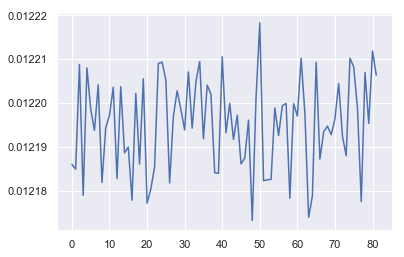

----
0c3@4fc[
VUwQNcCa!mUf$VXO,1/AC3Sy-NPR8Zt%@C7]MHtxuvS2 
vhb$0D;FAJ2hg"avv)TK7)12o6ht(;g@? GV8wdDn.tnMpZyUd)c:'pi
9ISfgI3[Gp[(3$SwEo %sH/02
Oc-GExbv(RF5G 77Z4QlF(Izn
EM$Kp.A8ApyUx)//lpUQ7 vjM(lM5fN)C(*c
----


In [9]:
def sample(h, seed_ix, n, plot=False):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        # feed forward
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        # choose proportional to probabilty
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        # set input to chosen character
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    if plot:
        last_p = p
        plt.plot(p.ravel())
        plt.show()
        
    txt = ''.join(ix_to_char[ix] for ix in ixes)
    print(f'----\n{txt}\n----')
    return ixes

prediction = sample(np.zeros((hidden_size, 1)), char_to_ix['a'], 200, plot=True)

## Training

We're using [Adagrad](https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html?highlight=adagrad#adagrad)

In [10]:
n, p = 0, 0 # n is training step (of a 25 sequence), p is pointer within data
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
while n <= 1000*100:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    # check "How to feed the loss function to see how this part works
    if p+seq_length+1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size,1)) # reset RNN memory
        p = 0 # go from start of data
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # forward seq_length characters through the net and fetch gradient
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossF(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001

    # sample from the model now and then
    if n % 1000 == 0:
        print(f'iter {n}, loss: {smooth_loss:.2f}') # print progress
        sample(hprev, inputs[0], 200, plot=False)

    # perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                  [dWxh, dWhh, dWhy, dbh, dby],
                                  [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam # increases memory variable, which decreases learning rate
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

    p += seq_length # move data pointer
    n += 1 # iteration counter

iter 0, loss: 110.17
----
H[M@(DT6.*(SNaXl5HE!K6np:xJL6Os4Buf2)RpXAa1p6-hL-hH846
R2TS2Anu3ad?.(X[kJ'G@MXtuB%Va4SiMpZ)qgqg"p-c%DTY4dSmPiYsR[oetp8WAtgIjq(4)qbKn%OwilDJ
o)EylS20spy5r7'2vUQ239mDor"8eBQ GY"izKpl@AD-e]jO6zAFNE/ PoJ 
----
iter 1000, loss: 87.47
----
te a nedis xitiintocninenmps itoa hugsetoe oasso cnudubatis envunto zei tum itEe furoca
 'itcim
 Neremib
  hrobrumormor , Tatomur ducin arle tavbus a8cm
  eume fopma pa cet icmaq, efaca. ricse oltoris
----
iter 2000, loss: 70.54
----
seminam ataS fcquatis arlata mando veces ardcves ititis axas, asques -anece cepguas

  Lmici aeno vanii digs rissle
 vorsule te maor aestero Ctafomum, epPais ervitoreP yfleta lesem.
 

 Ne fendam re T
----
iter 3000, loss: 62.45
----
darum lerdae Dett.

  im odit:.  Torit or nermuum, tencita carvum lools danis mormorum superrite pum comurire dos.

  Aentur aaviuntque recdo gionu lageustura.
  Sirrtuste surr, num pot ro tuntis
  ni
----
iter 4000, loss: 58.95
----
orunind fullaet?  omrun turtue siam pu

iter 35000, loss: 50.09
----
ne?  Te nium suver mugros,
  qui avortum aura
  Arnocpit.
  Tos proctali ilva teres exero tratratra ted obra lurtas.  et antem mezeni,
  dicetos condium in gnetratim.'  Quiit porcum aepi, Initus, focc
----
iter 36000, loss: 49.94
----
prina fentis exte tollius ucum crumsulo
  scungix Lorcibe subulis, nogummaeque susulatque depitr,'
  ned ter?
  Nem dupeave condium lete merqui cun cic incerquet agvit relea vorta cerdos
  cacrimum au
----
iter 37000, loss: 49.89
----
e sopciperaqui alicrem ubfecisus vetra Tulra
  fuidenat ebcustius immiciit turgunum et pupentum
  num llaereru libenti onit caferatum dosgem es precedit quo celvas at aeti Tarum
  stuura.

  Silta nan
----
iter 38000, loss: 49.71
----
urmis.  Durtro
  sa mage aego
  nonguit cSiquantesum perremna
  et gelte portune et bitit hiurana vilibit, no pitit horae difeas vurti, varis et molendes ocavi
  xoecinia in ditener:
  Etnas:  et gevi
----
iter 39000, loss: 59.21
----
or
  in hae indim nthonoc iadem

iter 70000, loss: 49.08
----
e mommo,
  Cocriiaere, quom nenebus Aenum gior viriom ollim dixe partibusque tancra eri accurea fordati silae dior tonimum.  Hi congistine mubiti panio; viripe hulcomit.
  Pomabis
  cercereque arfatae
----
iter 71000, loss: 49.06
----
api erdumem;
,
  orati
  com Noquor vistita quiniconis
  censenduce, latitus aprit sol,
  veptorit unquem terim stoeritque feam laeritur uraes:
  prtalanti inde nese suid pulid pacta,
  patri paterant
----
iter 72000, loss: 49.08
----
rae Lattanus udque suphum premae tenibus achum Truibus
  Aezenta codiat;
  cum pases una rares
  illus aupces,
  dequite pet ioser venes, dubta patas semphostra mede menam obtrossa.
  Masthun sen gres
----
iter 73000, loss: 48.91
----
e renebi dosuratat hontos pate corde faudis Aillaque imliuvera teraeta porvis, negues, isset

  'Hocinge
  sumphium platur insenima magnae tercentum
  prorentem terateret panenes parmine morum, causti
----
iter 74000, loss: 48.49
----
s, rters secium volgitur;
  ru 

## result

Let's create a function which displays our work more beautifully!

In [11]:
def tell_a_story(beginning, n):
    """
    write a story of length n with the given beginning
    beginning is a string
    n is an integer
    """
    h = np.zeros((hidden_size, 1)) # start with hidden state zero
    # build hidden state from beginning
    for char in beginning[:-1]:
        # create input vector
        x = vec_from_char(char)
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        # we don't need to calculate y and p as we are 
        # just building up the hidden state
        
    # print of function is story
    story = beginning
    x = vec_from_char(beginning[-1])
    for t in range(n):
        # predict
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        # set prediction
        char = ix_to_char[np.random.choice(range(vocab_size), p=p.ravel())]
        story += char
        # set new x to this time's prediction
        x = vec_from_char(char)
        
    print(story)

In [14]:
tell_a_story('  ARMA virumque cano', 1000)

  ARMA virumque canorem, qui regea capis
  insustum Guris adveribus altero talis,, sissi dum comum
  ieserius, patrunt illue prnorus, quaeterit
  salius urat--' Allucerior ac tergent aeter et virere dacre fircet enos,
  modine prosaborsa anus urbe audaque et fecoliis admour pirmine masso, cumproro
  Tenis
  dito camerem nuverat, exat parrpit Gitetiens impiateres;
  ux, siseremque perditur haurupe
  pora saca replomediusque octes,
  et omis,
, primo mivi egileante cramis ic voce mini cocristam, suin et eb orbitersis, ersus aunti, ignare mutra sdindis:
  forroqiam tanum
  et comorrisque restixine Trulames, heves, fypfluat
  cridipe tani; aucama furgum fucidas
  excurngunt
  camporis et facum ritan inserricuis mallusque aerus ceriiscum
  erona quam stimus proea canu copus,
  quid mora hamnia peditur, seres mecuia cur coneri.
  He pitis et moentia Teulasque orbaque turium corredi, aorra donitere, soriabis
  nae et victurer; agerum
  dis semptes, peria subeltis Daens et eter.
  Malla caplum